In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join, basename,exists
from glob import glob
from tqdm import tqdm

from obspy import read
from scipy.signal import correlate, correlation_lags, butter, filtfilt, spectrogram
from numpy.fft import fft, fftfreq, ifft, fftshift

ac_calib = 8.2928e-05

in_dir = '/home/zacharykeskinen/data/infrasound/infrasound/processed' #infrasound/banner/infrasound/processed/'
exists(in_dir)

# l = os.listdir(in_dir)
l = glob(os.path.join(in_dir, 'c0be4*'))
r = []
for i in l:
    i = os.path.basename(i)
    j = i[5:11]
    if j not in r:
        r.append(j)
r.sort()

In [3]:
name_dic = {'be4':'lower','a3m':'upper','ad8':'failed array'}
height_dic = {'lower-p0':0.33,'lower-p1':0.66,'lower-p2':1,'upper-p0':1.33,'upper-p1':np.nan,'upper-p2':2}
full_res = {}
for i, day in tqdm(enumerate(r), desc = 'days'):
    if day == '220310':
        print(day)

days: 104it [00:00, 367178.13it/s]

220310


In [4]:
def high_pass_filter(arr, order, fc, sps = 200):
    b, a = butter(order, fc, 'high', fs = sps)

    return filtfilt(b, a, arr)

In [5]:
name_dic = {'be4':'lower','a3m':'upper','ad8':'failed array'}
height_dic = {'lower-p0':0.33,'lower-p1':0.66,'lower-p2':1,'upper-p0':1.33,'upper-p1':np.nan,'upper-p2':2}
full_res = {}
for i, day in tqdm(enumerate(r), desc = 'days'):
    if day == '220310':
        ls = glob(join(in_dir, '*'+day+'*'))
        res = {}
        for file in ls:
                name = name_dic[basename(file).replace(day,'')[2:5]]
                if name != 'failed array':
                    tr = read(file)[0]
                    stats = tr.stats
                    sps = stats['sampling_rate']
                    start = stats['starttime']
                    end = stats['endtime']
                    channel = stats['channel']
                    name_channel = f'{name}-{channel}'
                    height = height_dic[name_channel]
                    if not np.isnan(height):
                        arr = tr.data
                        arr = arr * ac_calib
                        arr = arr - np.nanmean(arr)

                        arr_filt = high_pass_filter(arr, 2, 1/10)
                        res[height] = arr_filt
        
        full_res[day] = res

days: 104it [00:04, 21.35it/s]


In [6]:
def plot_helioquarter(data_dict, height, date):
    hour_samps = int(data_dict[height].shape[0]/24)
    res_hourly = data_dict[height].reshape(24, hour_samps)
    f, axes = plt.subplots(24, figsize = (30, 10))
    t = np.linspace(0, 60, res_hourly.shape[1])
    for hour in range(res_hourly.shape[0]):
        ax = axes[hour]
        ax.plot(t, res_hourly[hour, :])
        ax.set_ylim(-2.5, 2.5)
        ax.get_yaxis().set_visible(False)
        if hour == 23:
            ax.set_xlabel('Minutes')
        if hour == 0:
            ax.set_title(f'{date} Helioquarter at {height} m')

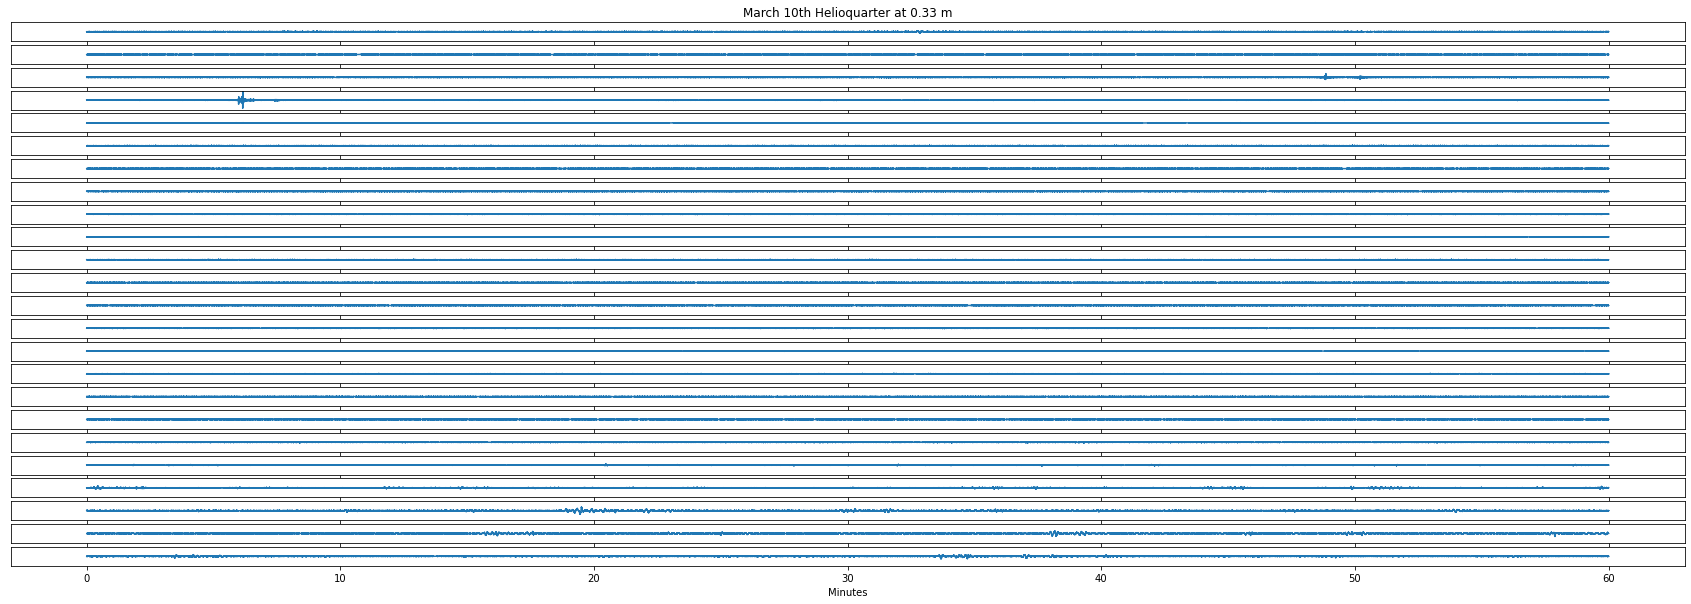

In [6]:
plot_helioquarter(res, 0.33, 'March 10th')

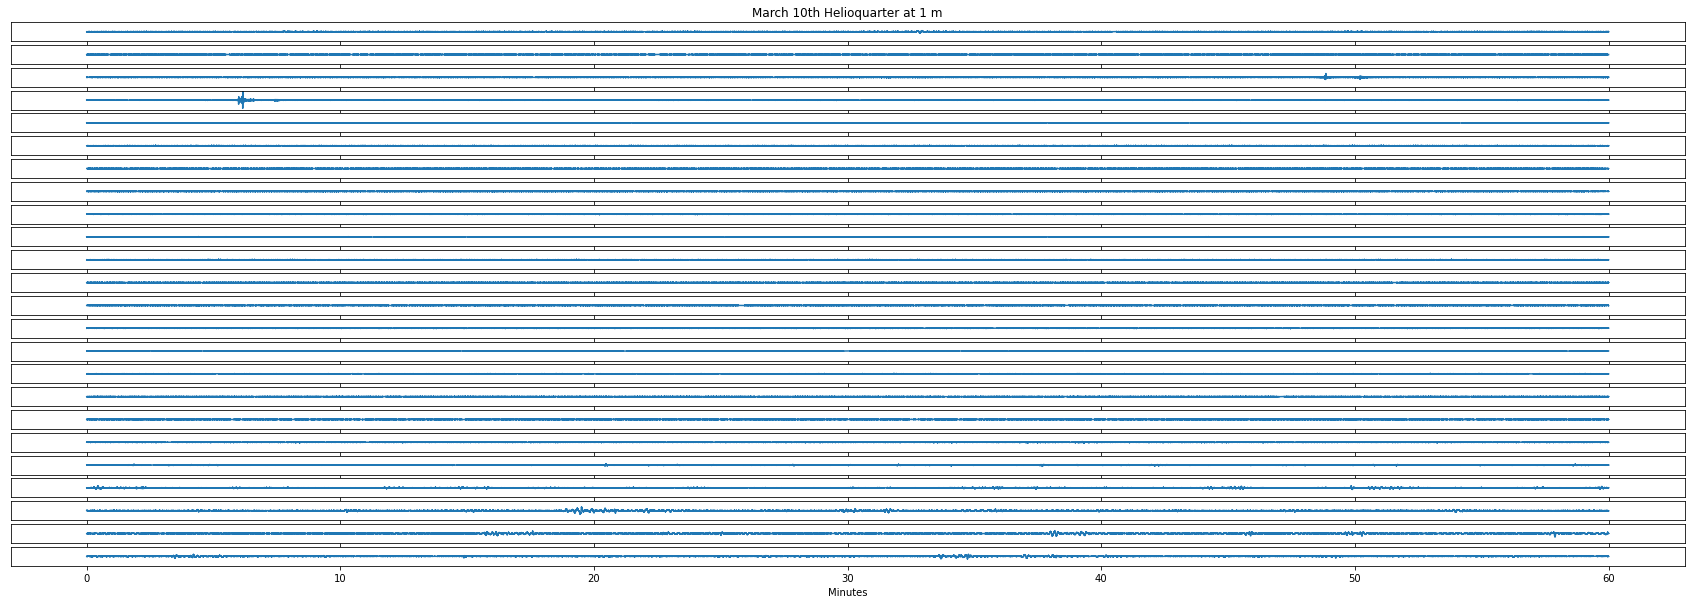

In [7]:
plot_helioquarter(res, 1, 'March 10th')

In [8]:
def plot_helioquarter_spectrogram(data_dict, height, date, vmax = 0.000001):
    hour_samps = int(data_dict[height].shape[0]/24)
    res_hourly = data_dict[height].reshape(24, hour_samps)
    f, axes = plt.subplots(24, figsize = (20, 20))
    t = np.linspace(0, 60, res_hourly.shape[1])
    for hour in range(res_hourly.shape[0]):
        ax = axes[hour]
        f, t, Sxx = spectrogram(res_hourly[hour, :], fs = 200)
        t = t / 60
        ax.pcolormesh(t, f, Sxx, shading='gouraud', vmin = 0, vmax = vmax)
        # ax.set_ylim(-2.5, 2.5)
        ax.get_yaxis().set_visible(False)
        if hour == 23:
            ax.set_xlabel('Minutes')
        if hour == 0:
            ax.set_title(f'{date} Spectrogram at {height} m')

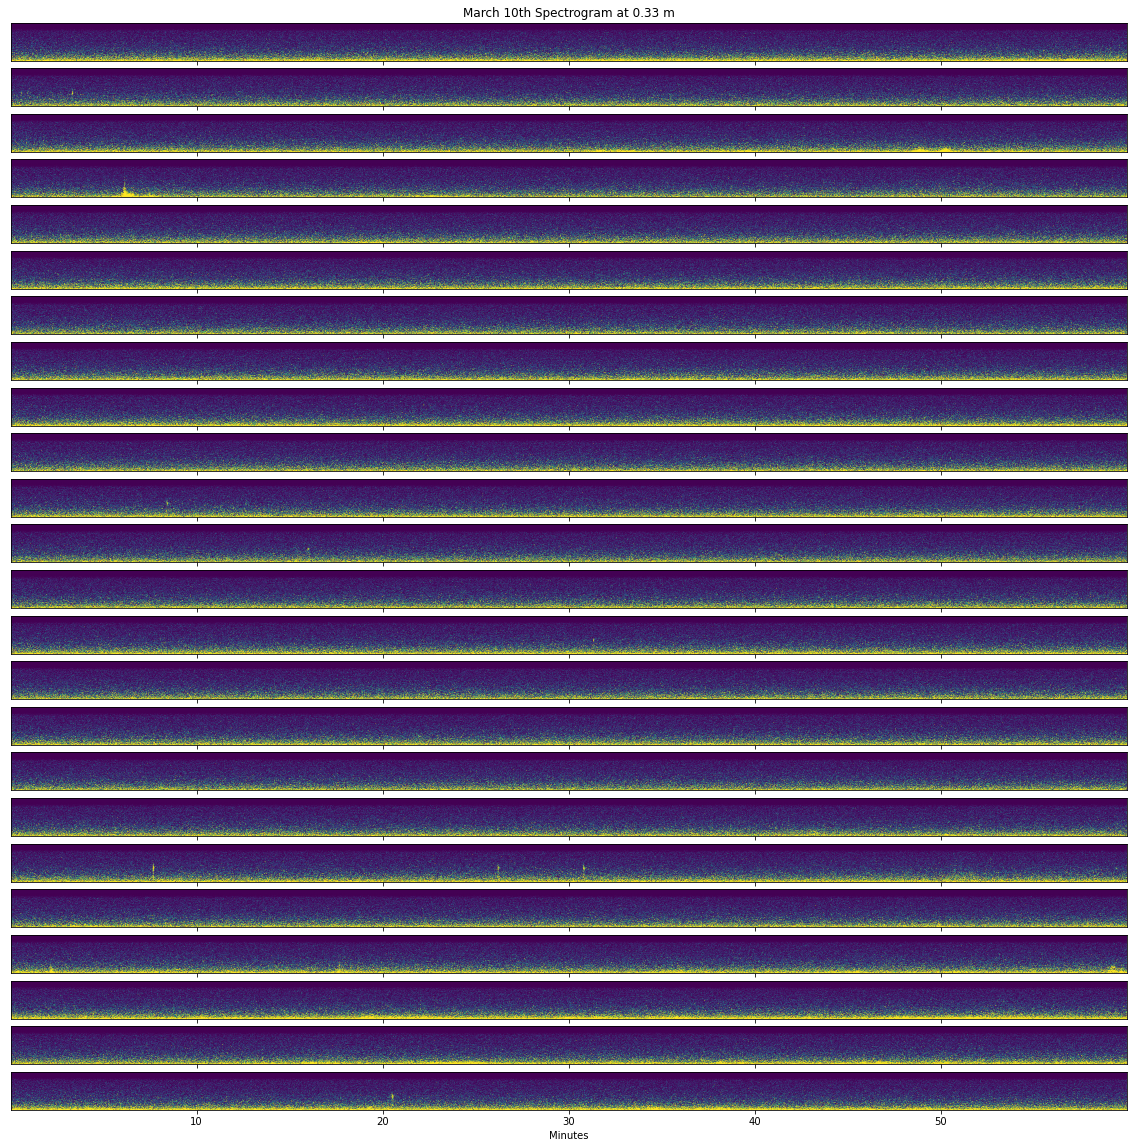

In [9]:
plot_helioquarter_spectrogram(res, 0.33, 'March 10th')

In [10]:
def correlation_plot(data_dic, height_1, height_2, date, wind_len_sec, fc, sps = 200):
    hour_samps = int(res[height_1].shape[0]/24)
    res_hourly_1 = high_pass_filter(data_dic[height_1], 2, fc)
    res_hourly_1 = res_hourly_1.reshape(24, hour_samps)
    res_hourly_2 = high_pass_filter(data_dic[height_2], 2, fc)
    res_hourly_2  = res_hourly_2.reshape(24, hour_samps)
    f, axes = plt.subplots(24, figsize = (20, 20))
    for hour in range(res_hourly_1.shape[0]):
        wind = wind_len_sec * sps
        arr1 = np.reshape(res_hourly_1[hour], (int(wind),int(len(res_hourly_1[hour])/wind)), 'F')
        #arr2 = arr2.reshape(-1, int(wind))
        arr2 = np.reshape(res_hourly_2[hour], (int(wind),int(len(res_hourly_2[hour])/wind)), 'F')

        # now compute Pearson
        xcorr0lag = np.sum(arr1*arr2, axis = 0)
        #xcorr0lag = sum(arr1*arr2)
        normalization = np.sqrt(np.sum(arr1**2, axis = 0)*np.sum(arr2**2, axis = 0))
        Pcoeff = xcorr0lag/normalization
        ax = axes[hour]
        t = np.linspace(0, 60, Pcoeff.size)
        ax.plot(t, Pcoeff)
        ax.set_ylim(0,1)
        ax.set_xlim(0,60)
        ax.get_yaxis().set_visible(False)
        if hour == 23:
            ax.set_xlabel('Minutes')
        if hour == 0:
            ax.set_title(f'{date} - Correlation between {height_1} and {height_2} m')

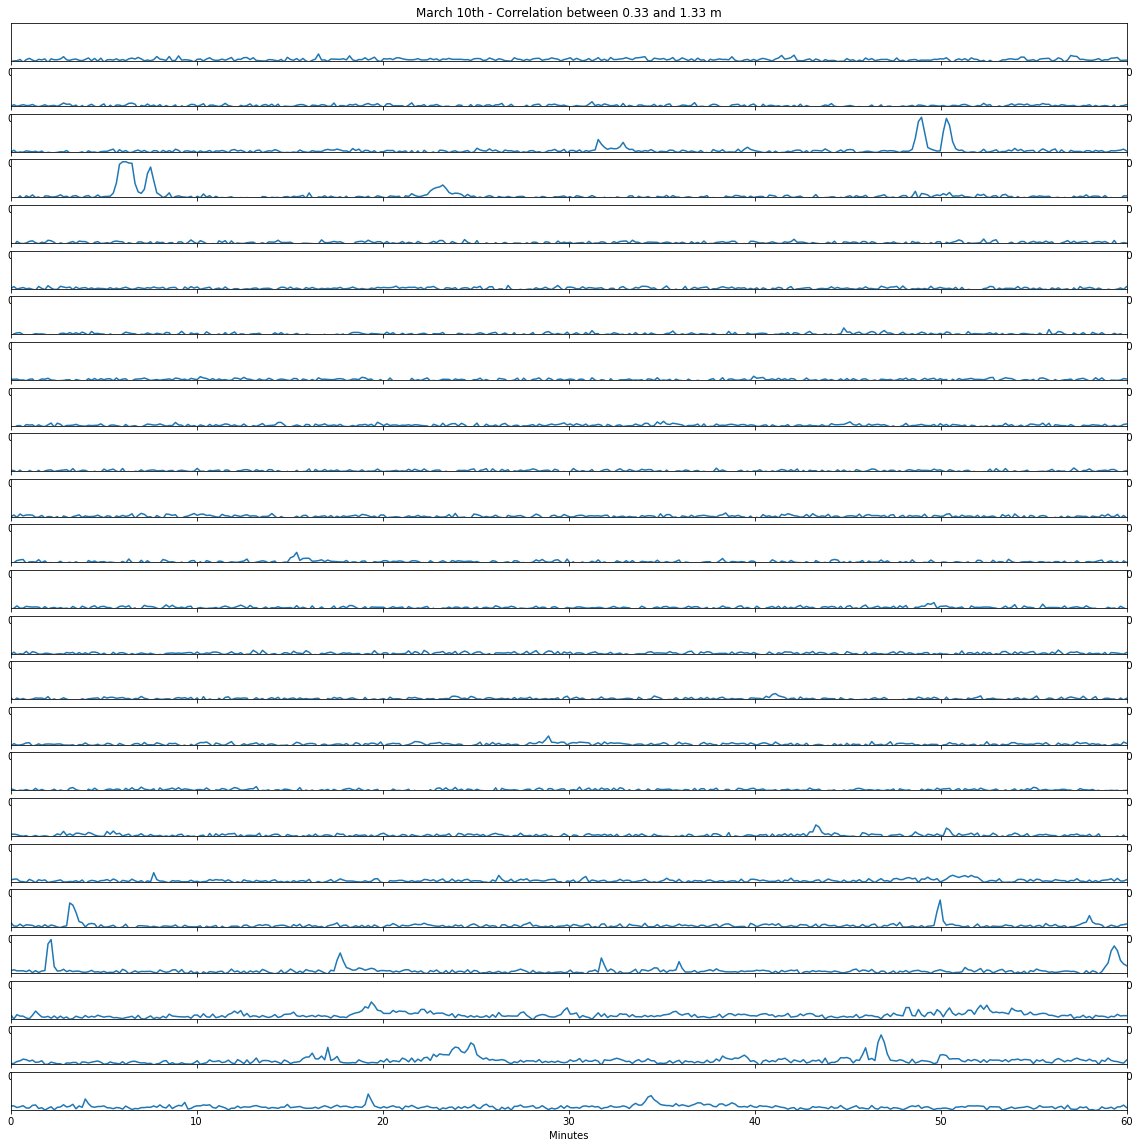

In [11]:
correlation_plot(res, 0.33, 1.33, 'March 10th', fc = 5, wind_len_sec = 10)

In [10]:
earthquake_time = '18:26:10'
day = res[0.33].reshape(24,-1)

In [14]:
eq_hour = int(earthquake_time.split(':')[0])
hour = day[eq_hour]

In [ ]:
def correlation_hour(data_dic,eq_hour, height_1, height_2, date, wind_len_sec, fc, sps = 200):
    hour_samps = int(res[height_1].shape[0]/24)
    res_hourly_1 = high_pass_filter(data_dic[height_1], 2, fc)
    res_hourly_1 = res_hourly_1.reshape(24, hour_samps)
    res_hourly_2 = high_pass_filter(data_dic[height_2], 2, fc)
    res_hourly_2  = res_hourly_2.reshape(24, hour_samps)
    f, axes = plt.subplots(1, figsize = (20, 20))
    for hour in range(res_hourly_1.shape[0]):
        if hour == eq_hour-1:
            wind = wind_len_sec * sps
            arr1 = np.reshape(res_hourly_1[hour], (int(wind),int(len(res_hourly_1[hour])/wind)), 'F')
            #arr2 = arr2.reshape(-1, int(wind))
            arr2 = np.reshape(res_hourly_2[hour], (int(wind),int(len(res_hourly_2[hour])/wind)), 'F')

            # now compute Pearson
            xcorr0lag = np.sum(arr1*arr2, axis = 0)
            #xcorr0lag = sum(arr1*arr2)
            normalization = np.sqrt(np.sum(arr1**2, axis = 0)*np.sum(arr2**2, axis = 0))
            Pcoeff = xcorr0lag/normalization
            ax = axes[hour]
            t = np.linspace(0, 60, Pcoeff.size)
            ax.plot(t, Pcoeff)
            ax.set_ylim(0,1)
            ax.set_xlim(0,60)
            ax.get_yaxis().set_visible(False)
            ax.set_xlabel('Minutes')
            ax.set_title(f'{date} - Correlation between {height_1} and {height_2} m')

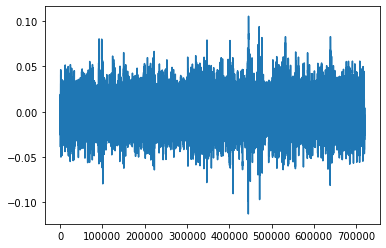

In [15]:
correlation_plot(res, 18, 0.33, 1.33, 'March 10th', fc = 5, wind_len_sec = 10)

In [ ]:
def correlation_plot(data_dic, height_1, height_2, date, wind_len_sec, fc, sps = 200):
    hour_samps = int(res[height_1].shape[0]/24)
    res_hourly_1 = high_pass_filter(data_dic[height_1], 2, fc)
    res_hourly_1 = res_hourly_1.reshape(24, hour_samps)
    res_hourly_2 = high_pass_filter(data_dic[height_2], 2, fc)
    res_hourly_2  = res_hourly_2.reshape(24, hour_samps)
    f, axes = plt.subplots(24, figsize = (20, 20))
    for hour in range(res_hourly_1.shape[0]):
        wind = wind_len_sec * sps
        arr1 = np.reshape(res_hourly_1[hour], (int(wind),int(len(res_hourly_1[hour])/wind)), 'F')
        #arr2 = arr2.reshape(-1, int(wind))
        arr2 = np.reshape(res_hourly_2[hour], (int(wind),int(len(res_hourly_2[hour])/wind)), 'F')

        # now compute Pearson
        xcorr0lag = np.sum(arr1*arr2, axis = 0)
        #xcorr0lag = sum(arr1*arr2)
        normalization = np.sqrt(np.sum(arr1**2, axis = 0)*np.sum(arr2**2, axis = 0))
        Pcoeff = xcorr0lag/normalization
        ax = axes[hour]
        t = np.linspace(0, 60, Pcoeff.size)
        ax.plot(t, Pcoeff)
        ax.set_ylim(0,1)
        ax.set_xlim(0,60)
        ax.get_yaxis().set_visible(False)
        if hour == 23:
            ax.set_xlabel('Minutes')
        if hour == 0:
            ax.set_title(f'{date} - Correlation between {height_1} and {height_2} m')